In [1]:
import os
import time
import csv

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
import matplotlib as mpl
from igraph import Graph
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh, eigvals

from utils import *
%matplotlib inline

In [ ]:
df_info = pd.read_csv("real_graphs_data.csv")

category_map = {
    'Collaboration networks': 'Collaboration',
    'Social networks': 'Social',
    'Miscellaneous Networks': 'Miscellaneous',
    'Biological Networks': 'Biological'
}


all_results = []

for idx, row in df_info.iterrows():
    graph_name = row['graph_name']
    category_str = row['category']
    n = int(row['num_nodes'])

    category = category_map.get(category_str, "Unknown")

    base_dir = "Networks"
    file_path = os.path.join(base_dir, category_str, f"{graph_name}.txt")

    if not os.path.exists(file_path):
        found = False
        for ext in ['.txt', '.edges', '.csv']:
            alt_path = os.path.join(base_dir, category_str, f"{graph_name}{ext}")
            if os.path.exists(alt_path):
                file_path = alt_path
                found = True
                break

        if not found:
            print(f"File not found for {graph_name}")
            all_results.append({
                'graph': graph_name,
                'category': category,
                'spectral_index_GP': None
            })
            continue

    try:
        G = nx.Graph()

        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue

                parts = line.split()
                if len(parts) < 2:
                    continue

                u, v = parts[0].strip(), parts[1].strip()
                if u and v:
                    G.add_edge(u, v)

        if G.number_of_nodes() != n:
            print(
                f"Node count mismatch for {graph_name}: "
                f"CSV={n}, Actual={G.number_of_nodes()}"
            )

        P = stochastic_matrix_calculator(G)
        spectral_index = estrada_index_using_p(G, P, k_max=10)

        all_results.append({
            'graph': graph_name,
            'category': category,
            'spectral_index_GP': (
                round(spectral_index, 6)
                if not np.isnan(spectral_index) else None
            )
        })

        print(
            f"{graph_name} | Nodes: {n} | "
            f"SpectralIndex: {spectral_index:.6f}"
        )

    except Exception as e:
        print(f"Error processing {graph_name}: {e}")
        all_results.append({
            'graph': graph_name,
            'category': category,
            'spectral_index_GP': None
        })


final_df = pd.DataFrame(all_results)
output_file = "total_real_networks_E,E-L_filled.csv"
final_df.to_csv(output_file, index=False)

print(f"Done! Results saved to: {os.path.abspath(output_file)}")
print("Preview:")
print(final_df.head(10))

In [ ]:
df_info = pd.read_csv("real_graphs_data.csv")

category_map = {
    'Collaboration networks': 'Collaboration',
    'Social networks': 'Social',
    'Miscellaneous Networks': 'Miscellaneous',
    'Biological Networks': 'Biological'
}

all_results = []

for idx, row in df_info.iterrows():
    graph_name = row['graph_name']
    category_str = row['category']
    n = int(row['num_nodes'])
    m = int(row['num_edges'])

    category = category_map.get(category_str, "Unknown")

    base_dir = "Networks"
    file_path = os.path.join(base_dir, category_str, f"{graph_name}.txt")

    if not os.path.exists(file_path):
        found = False
        for ext in ['.txt', '.edges', '.csv']:
            alt_path = os.path.join(base_dir, category_str, f"{graph_name}{ext}")
            if os.path.exists(alt_path):
                file_path = alt_path
                found = True
                break
        if not found:
            print(f"File not found for {graph_name}")
            all_results.append({
                'graph': graph_name,
                'category': category,
                'energy': None,
                'laplacian_energy': None
            })
            continue

    try:
        G = nx.Graph()
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                parts = line.split()
                if len(parts) < 2:
                    continue
                u, v = parts[0].strip(), parts[1].strip()
                if u and v:
                    G.add_edge(u, v)

        if G.number_of_nodes() != n or G.number_of_edges() != m:
            print(f"Count mismatch for {graph_name}: CSV=({n}, {m}), Actual=({G.number_of_nodes()}, {G.number_of_edges()})")

        energy, laplacian_energy = compute_energies(G)

        all_results.append({
            'graph': graph_name,
            'category': category,
            'energy': round(energy, 6) if not np.isnan(energy) else None,
            'laplacian_energy': round(laplacian_energy, 6) if not np.isnan(laplacian_energy) else None
        })

        print(f"{graph_name} | Nodes: {n} | Energy: {energy:.4f} | LapEnergy: {laplacian_energy:.4f}")

    except Exception as e:
        print(f"Error processing {graph_name}: {e}")
        all_results.append({
            'graph': graph_name,
            'category': category,
            'energy': None,
            'laplacian_energy': None
        })

final_df = pd.DataFrame(all_results)
output_file = "real_networks_energies_.csv"
final_df.to_csv(output_file, index=False)

print(f"Done! Results saved to: {os.path.abspath(output_file)}")
print("Summary:")
print(final_df[['graph', 'category', 'energy', 'laplacian_energy']].head(10))

In [ ]:
def compute_energies(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    
    if n == 0:
        return np.nan, np.nan

    k_dynamic = max(1, min(n - 1, int(round(0.0002 * n))))  

    try:
        if n <= 500:
            A_dense = nx.to_numpy_array(G, dtype=float)
            eigs_adj = eigh(A_dense, eigvals_only=True)
        else:
            k_adj = k_dynamic
            A_sparse = nx.to_scipy_sparse_array(G, format='csr', dtype=float)
            eigs_adj = eigsh(A_sparse, k=k_adj, which='LM', return_eigenvectors=False)
        energy = np.sum(np.abs(eigs_adj))
    except Exception as e:
        print(f"Adjacency energy failed (n={n}, k={k_dynamic}): {e}")
        energy = np.nan


    try:
        mu = (2 * m) / n
        if n <= 500:
            L_dense = nx.laplacian_matrix(G).astype(float).toarray()
            eigs_lap = eigh(L_dense, eigvals_only=True)
        else:
            k_lap = k_dynamic
            L_sparse = nx.laplacian_matrix(G).tocsr().astype(float)
            eigs_lap = eigsh(L_sparse, k=k_lap, which='LA', return_eigenvectors=False)
        laplacian_energy = np.sum(np.abs(eigs_lap - mu))
    except Exception as e:
        print(f"Laplacian energy failed (n={n}, k={k_dynamic}): {e}")
        laplacian_energy = np.nan

    return energy, laplacian_energy



categories = {
    'Collaboration': 'Networks/Collaboration networks',
    'Social': 'Networks/Social networks',
    'Miscellaneous': 'Networks/Miscellaneous Networks',
    'Biological': 'Networks/Biological Networks'
}



all_results = []

for category, path in categories.items():
    print(f"Processing {category} networks...")
    if not os.path.exists(path):
        print(f"Path not found: {path}")
        continue

    networks = read_real_networks(path)
    print(f"Found {len(networks)} networks.")

    start = time.time()
    category_results = []

    for key in tqdm(networks, desc=f"{category}"):
        G = networks[key]
        if not isinstance(G, nx.Graph):
            print(f"Skipping non-Graph object: {key}")
            continue

        energy, laplacian_energy = compute_energies(G) 

        category_results.append({
            'graph': key,
            'category': category,
            'energy': round(energy, 6) if not np.isnan(energy) else None,
            'laplacian_energy': round(laplacian_energy, 6) if not np.isnan(laplacian_energy) else None
        })

    df = pd.DataFrame(category_results)
    all_results.append(df)
    elapsed = time.time() - start
    print(f"Done in {elapsed:.2f} seconds.")

final_df = pd.concat(all_results, ignore_index=True)
output_file = "real_networks_energies.csv"
final_df.to_csv(output_file, index=False)

print(f"Results saved to: {os.path.abspath(output_file)}")
print(final_df.head())

In [ ]:
GRAPH_DIR = "Networks" 
OUTPUT_CSV = "real_graphs_data.csv"


with open(OUTPUT_CSV, mode='w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["graph_name", "category", "num_nodes", "num_edges"])

    for root, dirs, files in os.walk(GRAPH_DIR):
        for file in files:
            if file.endswith(".txt") or file.endswith(".edges") or file.endswith(".csv"):
                file_path = os.path.join(root, file)
                graph_name = os.path.splitext(file)[0]
                category = os.path.basename(root)    

                try:
                    G = nx.read_edgelist(file_path, nodetype=str, comments='#')
                    num_nodes = G.number_of_nodes()
                    num_edges = G.number_of_edges()

                    writer.writerow([graph_name, category, num_nodes, num_edges])
                    print(f"Processed: {graph_name} (Category: {category}) → Nodes: {num_nodes}, Edges: {num_edges}")

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

print(f"Data saved to {OUTPUT_CSV}")

# ---------------------------

In [2]:
PATH = 'Networks/Collaboration networks'
collab_networks = read_real_networks(PATH)
print(collab_networks.keys())
print(collab_networks['CA-CondMat'])

CA-Erdos992 is not connected!
CA-HepTh is not connected!
dict_keys(['CA-AstroPh', 'CA-cit-HepPh', 'CA-CondMat', 'CA-Erdos992', 'CA-GrQc', 'CA-HepTh', 'CA-sandi_auths'])
Graph with 21363 nodes and 91286 edges


In [3]:
collab_networks

{'CA-AstroPh': <networkx.classes.graph.Graph at 0x173b2ad68d0>,
 'CA-cit-HepPh': <networkx.classes.graph.Graph at 0x173b6645850>,
 'CA-CondMat': <networkx.classes.graph.Graph at 0x1738f85d3d0>,
 'CA-Erdos992': <networkx.classes.graph.Graph at 0x173c1ce3390>,
 'CA-GrQc': <networkx.classes.graph.Graph at 0x173c1f4a210>,
 'CA-HepTh': <networkx.classes.graph.Graph at 0x173c22ea590>,
 'CA-sandi_auths': <networkx.classes.graph.Graph at 0x173b6649d50>}

In [4]:
collab_networks.values()

dict_values([<networkx.classes.graph.Graph object at 0x00000173B2AD68D0>, <networkx.classes.graph.Graph object at 0x00000173B6645850>, <networkx.classes.graph.Graph object at 0x000001738F85D3D0>, <networkx.classes.graph.Graph object at 0x00000173C1CE3390>, <networkx.classes.graph.Graph object at 0x00000173C1F4A210>, <networkx.classes.graph.Graph object at 0x00000173C22EA590>, <networkx.classes.graph.Graph object at 0x00000173B6649D50>])

In [ ]:
collab_values = {}
start = time.time()
q_max = 0

for key in tqdm(collab_networks):
    collab_values[key] = dict()
    print(key)
    G = collab_networks[key]
    print("here1")
    n = G.number_of_nodes()
    print("here2")
    H, _ = calculate_H_geometric(G=G)
    print("here3")
    m2 = est_moment(G, 10000, 2)[1]
    estrada = estrada_index(G)
    print("here4")
    _, _, Q = synchronizability_calculator(G, for_real_networks=True)
    print("here5")
    gini = calculate_gini(G)

    if Q > q_max:
        q_max = Q 
    
    collab_values[key]['Gini'] = round(gini, 3)
    collab_values[key]['H'] = round(H, 3)
    collab_values[key]['m2']= round(m2, 3)
    collab_values[key]['Q']= round(Q, 3)
    collab_values[key]['estrada']= round(estrada, 3)
    

collab_df = pd.DataFrame(collab_values).T  
collab_df = collab_df.reset_index(drop=False).rename(columns={'index':'graph'})
collab_df['category'] = 'Collaboration'
end = time.time()
elapsed = end - start
collab_df.to_csv("SavedNetworks/collab_df.csv")
print(f'Time taken: {elapsed:.6f} seconds')
print("Q_max :", q_max)

In [3]:
collab_df = pd.read_csv("SavedNetworks/collab_df.csv")

In [8]:
collab_df["Q_norm"] = (np.log(collab_df["Q"]))
collab_df.to_csv('SavedNetworks/collab_df.csv', index=False)
collab_df

,Unnamed: 0,graph,Gini,H,m2,Q,estrada,category,Q_norm
0,0,CA-AstroPh,0.60,0.520,0.082,1.855945e+04,0.196,Collaboration,9.828734
1,1,CA-cit-HepPh,0.81,0.800,0.002,6.194848e+03,0.742,Collaboration,8.731473
2,2,CA-CondMat,0.50,0.364,0.148,6.105181e+03,0.168,Collaboration,8.716893
3,3,CA-Erdos992,0.59,0.477,0.100,3.934146e+03,0.541,Collaboration,8.277449
4,4,CA-GrQc,0.54,0.404,0.196,2.327446e+03,0.163,Collaboration,7.752527
5,5,CA-HepTh,0.51,0.366,0.248,3.398486e+15,0.158,Collaboration,35.762106
6,6,CA-sandi_auths,0.38,0.213,0.301,2.374430e+02,0.187,Collaboration,5.469928


In [5]:
collab_df = pd.read_csv("SavedNetworks/collab_df.csv")


cv_values = {}

for key in tqdm(collab_networks, desc="Computing CV"):
    G = collab_networks[key]
    
    degrees = np.array([d for _, d in G.degree()])
    
    if degrees.mean() != 0:
        cv = degrees.std() / degrees.mean()
    else:
        cv = np.nan
    
    cv_values[key] = round(cv, 3)

collab_df["CV"] = collab_df["graph"].map(cv_values)

collab_df.to_csv("SavedNetworks/collab_df.csv", index=False)

collab_df 


Computing CV: 100%|██████████| 7/7 [00:00<00:00, 162.76it/s]


,Unnamed: 0,graph,Gini,H,m2,Q,estrada,category,Q_norm,CV
0,0,CA-AstroPh,0.60,0.520,0.082,1.855945e+04,0.196,Collaboration,9.828734,1.409
1,1,CA-cit-HepPh,0.81,0.800,0.002,6.194848e+03,0.742,Collaboration,8.731473,3.355
2,2,CA-CondMat,0.50,0.364,0.148,6.105181e+03,0.168,Collaboration,8.716893,1.276
3,3,CA-Erdos992,0.59,0.477,0.100,3.934146e+03,0.541,Collaboration,8.277449,2.129
4,4,CA-GrQc,0.54,0.404,0.196,2.327446e+03,0.163,Collaboration,7.752527,1.336
5,5,CA-HepTh,0.51,0.366,0.248,3.398486e+15,0.158,Collaboration,35.762106,1.176
6,6,CA-sandi_auths,0.38,0.213,0.301,2.374430e+02,0.187,Collaboration,5.469928,0.801


In [6]:
PATH = 'Networks/Social networks'
social_networks = read_real_networks(PATH)
print(social_networks.keys())
print(social_networks['feather-lastfm-social'])


dict_keys(['feather-deezer-social', 'feather-lastfm-social', 'musae_facebook', 'musae_github', 'soc-twitter-follows', 'soc-youtube'])
Graph with 7624 nodes and 27806 edges


In [10]:
start = time.time()
social_values = dict()
excluded_keys = ['soc-twitter-follows', 'soc-youtube']

for key in tqdm(social_networks):
    if key in excluded_keys:
        continue
        
    social_values[key] = dict()
    G = social_networks[key]
    print(key,": ", G)
    n = G.number_of_nodes()
    H, _ = calculate_H_geometric(G=G)
    estrada = estrada_index(G)
    m2 = est_moment(G, 10000, 2)[1]
    _, _, Q = synchronizability_calculator(G, for_real_networks=True)
    gini = calculate_gini(G)


    social_values[key]['Gini'] = round(gini, 3)
    social_values[key]['H'] = round(H, 3)
    social_values[key]['m2'] = round(m2, 3)
    social_values[key]['Q'] = round(Q, 3)
    social_values[key]['estrada'] = round(estrada, 3)

social_df = pd.DataFrame(social_values).T  
social_df = social_df.reset_index(drop=False).rename(columns={'index':'graph'})
social_df['category'] = 'Social'
end = time.time()
elapsed = end - start
social_df.to_csv("SavedNetworks/social_df.csv")
print(f"Elapsed time:{elapsed: .2f} seconds")

  0%|          | 0/6 [00:00<?, ?it/s]

feather-deezer-social :  Graph with 28281 nodes and 92752 edges


 17%|█▋        | 1/6 [03:17<16:28, 197.77s/it]

feather-lastfm-social :  Graph with 7624 nodes and 27806 edges


 33%|███▎      | 2/6 [03:30<05:55, 88.80s/it] 

musae_facebook :  Graph with 22470 nodes and 171002 edges


 50%|█████     | 3/6 [05:51<05:38, 112.67s/it]

musae_github :  Graph with 37700 nodes and 289003 edges


100%|██████████| 6/6 [12:13<00:00, 122.27s/it]

Elapsed time: 733.65 seconds


In [14]:
social_df["Q_norm"] = (np.log(social_df["Q"]))
social_df.to_csv('SavedNetworks/social_df.csv', index=False)
social_df

,graph,Gini,H,m2,Q,estrada,category,Q_norm
0,feather-deezer-social,0.52,0.395,0.153,16599.606,0.207,Social,9.717134
1,feather-lastfm-social,0.58,0.466,0.160,3245.943,0.249,Social,8.085161
2,musae_facebook,0.62,0.531,0.107,22439.166,0.217,Social,10.018563
3,musae_github,0.69,0.607,0.067,81076.061,0.451,Social,11.303143


In [15]:
social_df.to_csv("SavedNetworks/social_df.csv")

In [17]:
social_df = pd.read_csv('SavedNetworks/social_df.csv')

In [10]:
social_df = pd.read_csv('SavedNetworks/social_df.csv')

cv_values = {}

for key in tqdm(social_networks, desc="Computing CV (Social)"):
    G = social_networks[key]
    
    degrees = np.array([d for _, d in G.degree()])
    
    if degrees.mean() != 0:
        cv = degrees.std() / degrees.mean()
    else:
        cv = np.nan
    
    cv_values[key] = round(cv, 3)

social_df["CV"] = social_df["graph"].map(cv_values)

social_df.to_csv("SavedNetworks/social_df.csv", index=False)

social_df


Computing CV (Social):   0%|          | 0/6 [00:00<?, ?it/s]

Computing CV (Social): 100%|██████████| 6/6 [00:00<00:00,  9.45it/s]


,Unnamed: 0,graph,Gini,H,m2,Q,estrada,category,Q_norm,CA-AstroPh,CA-cit-HepPh,CA-CondMat,CA-Erdos992,CA-GrQc,CA-HepTh,CA-sandi_auths,CV
0,0,feather-deezer-social,0.52,0.395,0.153,16599.606,0.207,Social,9.717134,1.409,3.355,1.276,2.129,1.336,1.176,0.801,1.211
1,1,feather-lastfm-social,0.58,0.466,0.160,3245.943,0.249,Social,8.085161,1.409,3.355,1.276,2.129,1.336,1.176,0.801,1.576
2,2,musae_facebook,0.62,0.531,0.107,22439.166,0.217,Social,10.018563,1.409,3.355,1.276,2.129,1.336,1.176,0.801,1.735
3,3,musae_github,0.69,0.607,0.067,81076.061,0.451,Social,11.303143,1.409,3.355,1.276,2.129,1.336,1.176,0.801,5.269


In [11]:
PATH = 'Networks/Miscellaneous Networks'
miscellaneous_networks = read_real_networks(PATH)
print(miscellaneous_networks.keys())
print(miscellaneous_networks['Karate_Club_33node'])

dict_keys(['Celegans_Metabolic_453node', 'Dolphins_63node', 'Karate_Club_33node', 'Polbooks_241node'])
Graph with 34 nodes and 78 edges


In [19]:
miscellaneous_values = dict()
excluded_keys = []
q_max = 0
for key in miscellaneous_networks:
    miscellaneous_values[key] = dict()
    G = miscellaneous_networks[key]
    n = G.number_of_nodes()
    print(key,': ', G)
    H, _ = calculate_H_geometric(G=G)
    print("here")
    m2 = est_moment(G, 10000, 2)[1]
    print("here2")
    _, _, Q = synchronizability_calculator(G, for_real_networks=True)
    print("here3")
    estrada = estrada_index(G)
    gini = calculate_gini(G)

    miscellaneous_values[key]['Gini'] = round(gini, 3)
    
    miscellaneous_values[key]['H'] = round(H, 3)
    miscellaneous_values[key]['m2'] = round(m2, 3)
    miscellaneous_values[key]['Q'] = round(Q, 3)
    miscellaneous_values[key]['estrada'] = round(estrada, 3)
miscellaneous_df = pd.DataFrame(miscellaneous_values).T  
miscellaneous_df = miscellaneous_df.reset_index(drop=False).rename(columns={'index':'graph'})
miscellaneous_df.to_csv('SavedNetworks/miscellaneous_df.csv', index=False)
miscellaneous_df['category'] = 'Miscellaneous'

Celegans_Metabolic_453node :  Graph with 453 nodes and 2040 edges
here
here2
here3
Dolphins_63node :  Graph with 62 nodes and 159 edges
here
here2
here3
Karate_Club_33node :  Graph with 34 nodes and 78 edges
here
here2
here3
Polbooks_241node :  Graph with 240 nodes and 1241 edges
here
here2
here3


In [20]:
miscellaneous_df['Q_norm'] = (np.log(miscellaneous_df["Q"]))
miscellaneous_df.to_csv('SavedNetworks/miscellaneous_df.csv', index=False)

In [21]:
miscellaneous_df = pd.read_csv('SavedNetworks/miscellaneous_df.csv')
miscellaneous_df

,graph,Gini,H,m2,Q,estrada,category,Q_norm
0,Celegans_Metabolic_453node,0.49,0.341,0.110,922.536,0.288,Miscellaneous,6.827126
1,Dolphins_63node,0.33,0.200,0.187,78.703,0.133,Miscellaneous,4.365681
2,Karate_Club_33node,0.39,0.215,0.173,38.710,0.269,Miscellaneous,3.656098
3,Polbooks_241node,0.52,0.370,0.058,189.839,0.367,Miscellaneous,5.246176


In [12]:
miscellaneous_df = pd.read_csv('SavedNetworks/miscellaneous_df.csv')

cv_values = {}

for key in tqdm(miscellaneous_networks, desc="Computing CV (Miscellaneous)"):
    G = miscellaneous_networks[key]
    
    degrees = np.array([d for _, d in G.degree()])
    
    if degrees.mean() != 0:
        cv = degrees.std() / degrees.mean()
    else:
        cv = np.nan
    
    cv_values[key] = round(cv, 3)

miscellaneous_df["CV"] = miscellaneous_df["graph"].map(cv_values)

miscellaneous_df.to_csv("SavedNetworks/miscellaneous_df.csv", index=False)

miscellaneous_df


Computing CV (Miscellaneous): 100%|██████████| 4/4 [00:00<00:00, 642.85it/s]


,graph,Gini,H,m2,Q,estrada,category,Q_norm,CV
0,Celegans_Metabolic_453node,0.49,0.341,0.110,922.536,0.288,Miscellaneous,6.827126,1.865
1,Dolphins_63node,0.33,0.200,0.187,78.703,0.133,Miscellaneous,4.365681,0.572
2,Karate_Club_33node,0.39,0.215,0.173,38.710,0.269,Miscellaneous,3.656098,0.833
3,Polbooks_241node,0.52,0.370,0.058,189.839,0.367,Miscellaneous,5.246176,1.448


In [13]:
PATH = 'Networks/Biological Networks'
biological_networks = read_real_networks(PATH)
print(biological_networks.keys())


bio-grid-human is not connected!
Silwood Park_153node is not connected!
dict_keys(['alpha', 'beta', 'bio-dmela', 'bio-grid-human', 'bio-grid-yeast', 'delta', 'Dyslexia_Cortex_64node', 'Florida ecosystem dry_128node_2106edge', 'Little Rock Lake_182node', 'Silwood Park_153node', 'Typical_Cortex_64node', 'Ythan Estuary_134node'])


In [23]:
biological_values = dict()
excluded_keys = ['bio-grid-human']
for key in biological_networks:
    if key in excluded_keys:
        continue
    biological_values[key] = dict()
    G = biological_networks[key]
    n = G.number_of_nodes()
    print(key,':', G)
    H, _ = calculate_H_geometric(G=G)
    m2= est_moment(G, 10000, 2)[1]
    _, _, Q = synchronizability_calculator(G, for_real_networks=True)
    estrada = estrada_index(G)
    gini = calculate_gini(G)


    biological_values[key]['Gini'] = round(gini, 3)
    biological_values[key]['H'] = round(H, 3)
    biological_values[key]['m2'] = round(m2, 3)
    biological_values[key]['Q'] = round(Q, 3)
    biological_values[key]['estrada'] = round(estrada, 3)
biological_df = pd.DataFrame(biological_values).T  
biological_df = biological_df.reset_index(drop=False).rename(columns={'index':'graph'})
biological_df.to_csv('SavedNetworks/biological_df.csv', index=False)
biological_df['category'] = 'Biological'    

alpha : Graph with 289 nodes and 1009 edges
beta : Graph with 289 nodes and 1026 edges
bio-dmela : Graph with 7393 nodes and 25569 edges
bio-grid-yeast : Graph with 6008 nodes and 156945 edges
delta : Graph with 290 nodes and 1004 edges
Dyslexia_Cortex_64node : Graph with 64 nodes and 1891 edges
Florida ecosystem dry_128node_2106edge : Graph with 128 nodes and 2075 edges
Little Rock Lake_182node : Graph with 183 nodes and 2452 edges
Silwood Park_153node : Graph with 154 nodes and 370 edges
Typical_Cortex_64node : Graph with 64 nodes and 1770 edges
Ythan Estuary_134node : Graph with 135 nodes and 600 edges


In [24]:
biological_df['Q_norm'] = (np.log(biological_df['Q']))
biological_df.to_csv('SavedNetworks/biological_df.csv', index=False)

In [25]:
biological_df = pd.read_csv('SavedNetworks/biological_df.csv')
biological_df

,graph,Gini,H,m2,Q,estrada,category,Q_norm
0,alpha,0.18,0.059,0.147,194.629,0.021,Biological,5.271095
1,beta,0.18,0.057,0.149,193.321,0.021,Biological,5.264352
2,bio-dmela,0.61,0.493,0.130,1665.605,0.317,Biological,7.417944
3,bio-grid-yeast,0.60,0.560,0.019,10366.167,0.327,Biological,9.246303
4,delta,0.18,0.062,0.154,189.181,0.022,Biological,5.242704
5,Dyslexia_Cortex_64node,0.04,0.017,0.016,4.298,0.009,Biological,1.458150
6,Florida ecosystem dry_128node_2106edge,0.25,0.114,0.029,57.619,0.068,Biological,4.053852
7,Little Rock Lake_182node,0.42,0.324,0.032,108.350,0.218,Biological,4.685367
8,Silwood Park_153node,0.58,0.446,0.159,263.334,0.388,Biological,5.573423
9,Typical_Cortex_64node,0.07,0.012,0.019,2.584,0.008,Biological,0.949339


In [14]:
biological_df = pd.read_csv('SavedNetworks/biological_df.csv')

cv_values = {}

for key in tqdm(biological_networks, desc="Computing CV (Biological)"):
    G = biological_networks[key]
    
    degrees = np.array([d for _, d in G.degree()])
    
    if degrees.mean() != 0:
        cv = degrees.std() / degrees.mean()
    else:
        cv = np.nan
    
    cv_values[key] = round(cv, 3)

biological_df["CV"] = biological_df["graph"].map(cv_values)

biological_df.to_csv("SavedNetworks/biological_df.csv", index=False)

biological_df

Computing CV (Biological): 100%|██████████| 12/12 [00:00<00:00, 827.10it/s]


,graph,Gini,H,m2,Q,estrada,category,Q_norm,CV
0,alpha,0.18,0.059,0.147,194.629,0.021,Biological,5.271095,0.313
1,beta,0.18,0.057,0.149,193.321,0.021,Biological,5.264352,0.322
2,bio-dmela,0.61,0.493,0.130,1665.605,0.317,Biological,7.417944,1.559
3,bio-grid-yeast,0.60,0.560,0.019,10366.167,0.327,Biological,9.246303,1.547
4,delta,0.18,0.062,0.154,189.181,0.022,Biological,5.242704,0.321
5,Dyslexia_Cortex_64node,0.04,0.017,0.016,4.298,0.009,Biological,1.458150,0.137
6,Florida ecosystem dry_128node_2106edge,0.25,0.114,0.029,57.619,0.068,Biological,4.053852,0.487
7,Little Rock Lake_182node,0.42,0.324,0.032,108.350,0.218,Biological,4.685367,0.786
8,Silwood Park_153node,0.58,0.446,0.159,263.334,0.388,Biological,5.573423,1.467
9,Typical_Cortex_64node,0.07,0.012,0.019,2.584,0.008,Biological,0.949339,0.140


In [15]:
combined_df = pd.concat([biological_df, collab_df, miscellaneous_df, social_df]).reset_index(drop=True)
combined_df

,graph,Gini,H,m2,Q,estrada,category,Q_norm,CV,Unnamed: 0,CA-AstroPh,CA-cit-HepPh,CA-CondMat,CA-Erdos992,CA-GrQc,CA-HepTh,CA-sandi_auths
0,alpha,0.18,0.059,0.147,1.946290e+02,0.021,Biological,5.271095,0.313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,beta,0.18,0.057,0.149,1.933210e+02,0.021,Biological,5.264352,0.322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bio-dmela,0.61,0.493,0.130,1.665605e+03,0.317,Biological,7.417944,1.559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bio-grid-yeast,0.60,0.560,0.019,1.036617e+04,0.327,Biological,9.246303,1.547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,delta,0.18,0.062,0.154,1.891810e+02,0.022,Biological,5.242704,0.321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Dyslexia_Cortex_64node,0.04,0.017,0.016,4.298000e+00,0.009,Biological,1.458150,0.137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Florida ecosystem dry_128node_2106edge,0.25,0.114,0.029,5.761900e+01,0.068,Biological,4.053852,0.487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Little Rock Lake_182node,0.42,0.324,0.032,1.083500e+02,0.218,Biological,4.685367,0.786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Silwood Park_153node,0.58,0.446,0.159,2.633340e+02,0.388,Biological,5.573423,1.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Typical_Cortex_64node,0.07,0.012,0.019,2.584000e+00,0.008,Biological,0.949339,0.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
combined_df = combined_df[combined_df['graph'] != 'CA-HepTh'].copy()

In [17]:
allowed_cols = [
    "graph", "Gini", "H", "m2", "Q",
    "estrada", "CV", "Q_norm", "category"
]

combined_df = combined_df[allowed_cols]

combined_df

,graph,Gini,H,m2,Q,estrada,CV,Q_norm,category
0,alpha,0.18,0.059,0.147,194.629,0.021,0.313,5.271095,Biological
1,beta,0.18,0.057,0.149,193.321,0.021,0.322,5.264352,Biological
2,bio-dmela,0.61,0.493,0.130,1665.605,0.317,1.559,7.417944,Biological
3,bio-grid-yeast,0.60,0.560,0.019,10366.167,0.327,1.547,9.246303,Biological
4,delta,0.18,0.062,0.154,189.181,0.022,0.321,5.242704,Biological
5,Dyslexia_Cortex_64node,0.04,0.017,0.016,4.298,0.009,0.137,1.458150,Biological
6,Florida ecosystem dry_128node_2106edge,0.25,0.114,0.029,57.619,0.068,0.487,4.053852,Biological
7,Little Rock Lake_182node,0.42,0.324,0.032,108.350,0.218,0.786,4.685367,Biological
8,Silwood Park_153node,0.58,0.446,0.159,263.334,0.388,1.467,5.573423,Biological
9,Typical_Cortex_64node,0.07,0.012,0.019,2.584,0.008,0.140,0.949339,Biological


In [18]:
combined_df.to_csv('SavedNetworks/real_networks_df.csv', index=False)

In [19]:
combined_df

,graph,Gini,H,m2,Q,estrada,CV,Q_norm,category
0,alpha,0.18,0.059,0.147,194.629,0.021,0.313,5.271095,Biological
1,beta,0.18,0.057,0.149,193.321,0.021,0.322,5.264352,Biological
2,bio-dmela,0.61,0.493,0.130,1665.605,0.317,1.559,7.417944,Biological
3,bio-grid-yeast,0.60,0.560,0.019,10366.167,0.327,1.547,9.246303,Biological
4,delta,0.18,0.062,0.154,189.181,0.022,0.321,5.242704,Biological
5,Dyslexia_Cortex_64node,0.04,0.017,0.016,4.298,0.009,0.137,1.458150,Biological
6,Florida ecosystem dry_128node_2106edge,0.25,0.114,0.029,57.619,0.068,0.487,4.053852,Biological
7,Little Rock Lake_182node,0.42,0.324,0.032,108.350,0.218,0.786,4.685367,Biological
8,Silwood Park_153node,0.58,0.446,0.159,263.334,0.388,1.467,5.573423,Biological
9,Typical_Cortex_64node,0.07,0.012,0.019,2.584,0.008,0.140,0.949339,Biological


In [4]:
combined_df = pd.read_csv('SavedNetworks/real_networks_df.csv')

In [5]:
mapping = combined_df[['graph']]
mapping.to_csv('SavedNetworks/real_graphs_annotation.csv', index=True)
print(mapping)

                                     graph
0                                    alpha
1                                     beta
2                                bio-dmela
3                           bio-grid-yeast
4                                    delta
5                   Dyslexia_Cortex_64node
6   Florida ecosystem dry_128node_2106edge
7                 Little Rock Lake_182node
8                     Silwood Park_153node
9                    Typical_Cortex_64node
10                   Ythan Estuary_134node
11                              CA-AstroPh
12                            CA-cit-HepPh
13                              CA-CondMat
14                             CA-Erdos992
15                                 CA-GrQc
16                          CA-sandi_auths
17              Celegans_Metabolic_453node
18                         Dolphins_63node
19                      Karate_Club_33node
20                        Polbooks_241node
21                   feather-deezer-social
22         

In [4]:
mapping = combined_df[['graph']]
print(mapping)

                                     graph
0                                    alpha
1                                     beta
2                                bio-dmela
3                           bio-grid-yeast
4                                    delta
5                   Dyslexia_Cortex_64node
6   Florida ecosystem dry_128node_2106edge
7                 Little Rock Lake_182node
8                     Silwood Park_153node
9                    Typical_Cortex_64node
10                   Ythan Estuary_134node
11                              CA-AstroPh
12                            CA-cit-HepPh
13                              CA-CondMat
14                             CA-Erdos992
15                                 CA-GrQc
16                          CA-sandi_auths
17              Celegans_Metabolic_453node
18                         Dolphins_63node
19                      Karate_Club_33node
20                        Polbooks_241node
21                   feather-deezer-social
22         

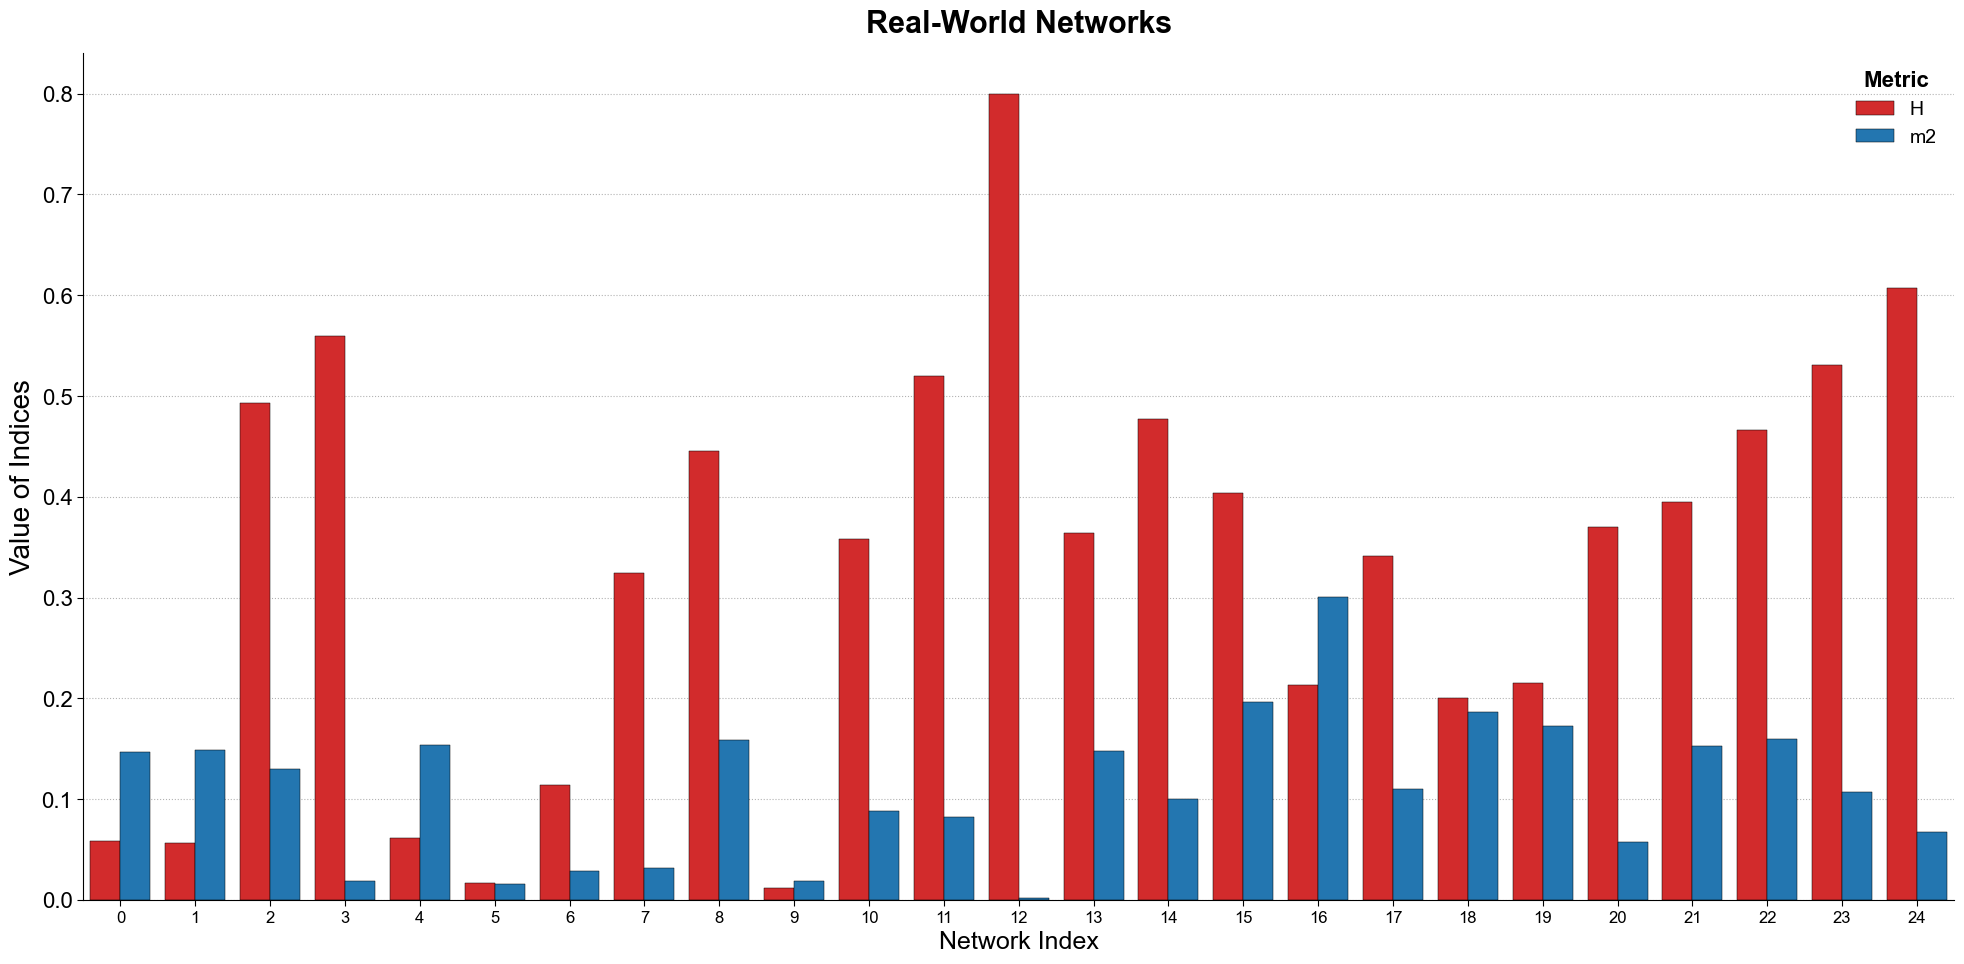

In [11]:
mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})


combined_df_reset = combined_df.reset_index(drop=True)
combined_df_reset['index'] = combined_df_reset.index  


df_long = pd.melt(
    combined_df_reset,
    id_vars=['index', 'category'],  
    value_vars=['H', 'm2'],
    var_name='Metric',
    value_name='Value'
)


plt.figure(figsize=(20, 10))
palette = {'H': '#D62728', 'm2': '#1F77B4'} 

ax = sns.barplot(
    data=df_long,
    x='index',
    y='Value',
    hue='Metric',
    palette=palette,
    edgecolor='black',
    linewidth=0.35,
    saturation=0.95
)


ax.set_xlabel('Network Index', fontsize=18)
ax.set_ylabel('Value of Indices', fontsize=20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=16)
ax.grid(axis='y', color='gray', linestyle=':', linewidth=0.8, alpha=0.6)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



legend = ax.legend(title='Metric', title_fontsize=16, fontsize=14, frameon=False, loc='upper right')
legend.get_title().set_weight('semibold')


ax.set_title('Real-World Networks', fontsize=22, fontweight='semibold', pad=15)
plt.tight_layout(pad=2.0)
plt.show()

C:\Users\Hossein\AppData\Local\Temp\ipykernel_16280\2547511906.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')


<Figure size 1000x600 with 0 Axes>

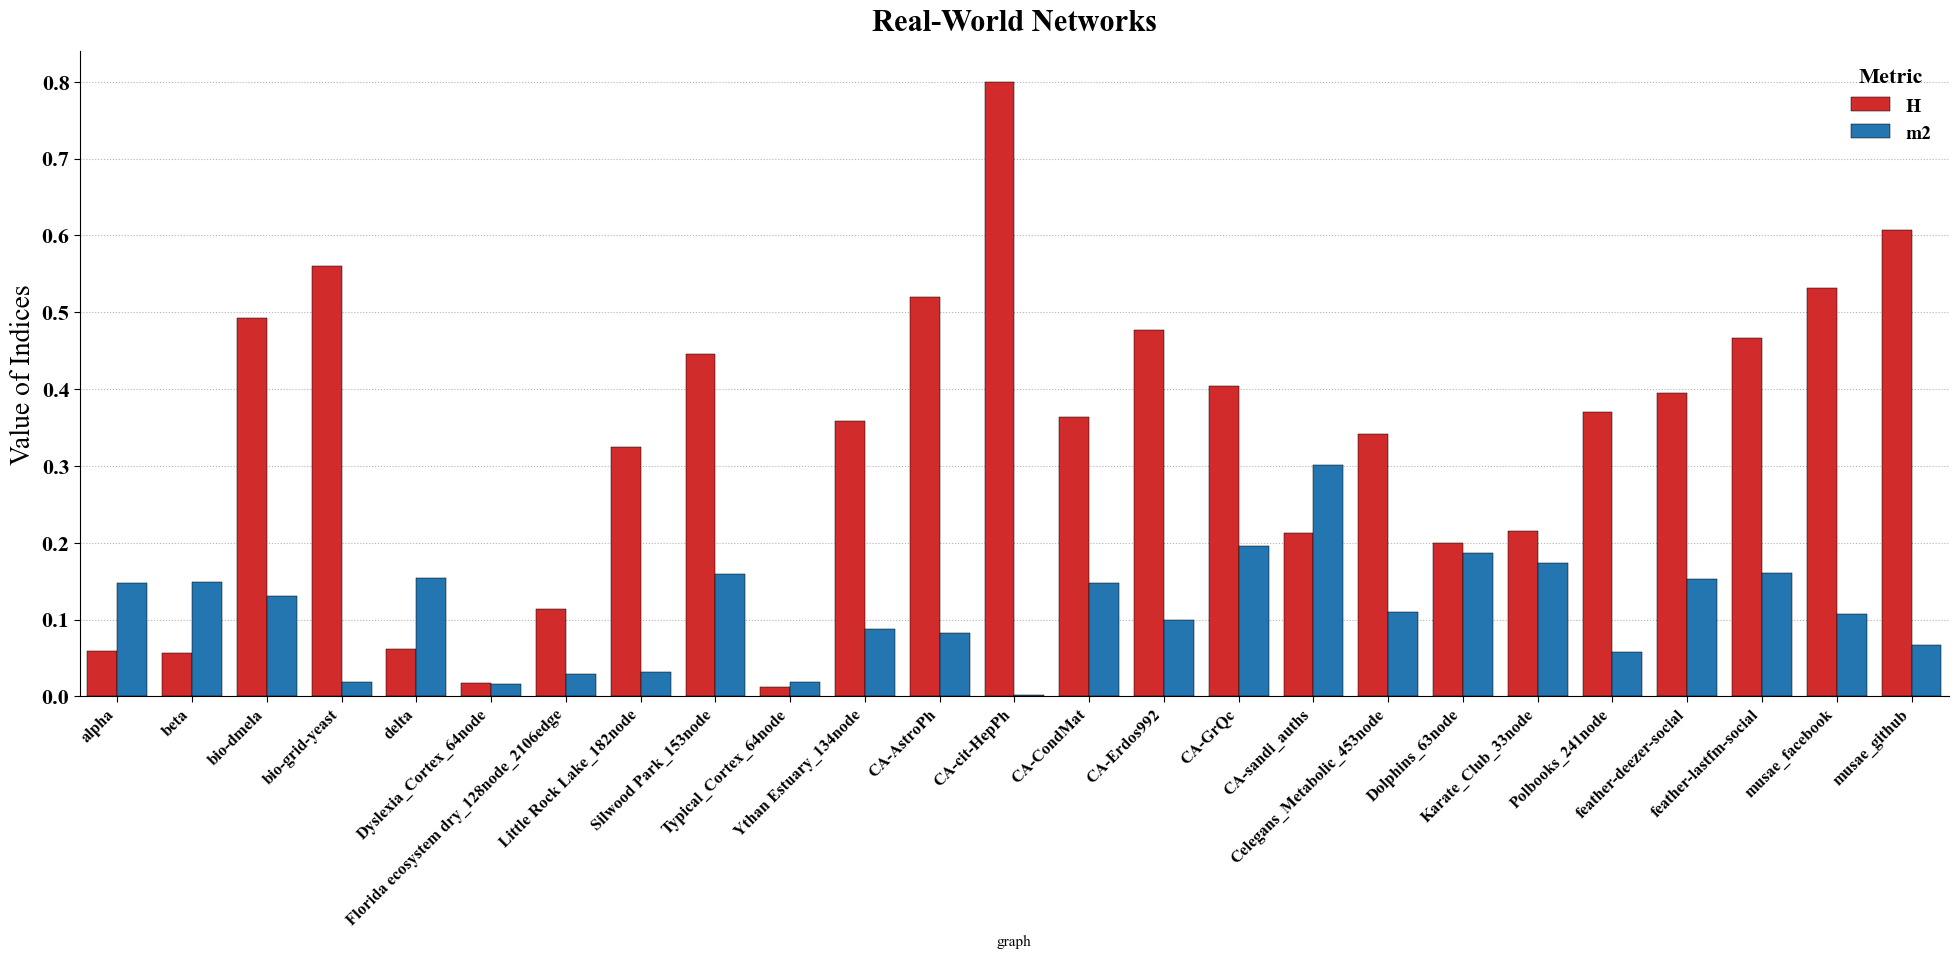

In [6]:
plt.figure(figsize=(10, 6))
font = {'family': 'times new roman', 'weight': 'bold', 'size': 11}

mpl.rcParams.update({
    'font.family': 'times new roman',
    'font.weight': 'bold',
    'font.size': 11,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})


combined_df_reset = combined_df.reset_index(drop=True)
combined_df_reset['index'] = combined_df_reset.index  


df_long = pd.melt(
    combined_df_reset,
    id_vars='graph',  
    value_vars=['H', 'm2'],
    var_name='Metric',
    value_name='Value'
)


plt.figure(figsize=(20, 10))
palette = {'H': '#D62728', 'm2': '#1F77B4'} 


ax = sns.barplot(
    data=df_long,
    x='graph',
    y='Value',
    hue='Metric',
    palette=palette,
    edgecolor='black',
    linewidth=0.35,
    saturation=0.95
)


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')

ax.set_ylabel('Value of Indices', fontsize=20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=16)
ax.grid(axis='y', color='gray', linestyle=':', linewidth=0.8, alpha=0.6)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# for container in ax.containers:
#     ax.bar_label(container, fmt='%.3f', fontsize=8, padding=2)


legend = ax.legend(title='Metric', title_fontsize=16, fontsize=14, frameon=False, loc='upper right')
legend.get_title().set_weight('semibold')


ax.set_title('Real-World Networks', fontsize=22, fontweight='semibold', pad=15)
plt.tight_layout(pad=2.0)
plt.show()

C:\Users\Hossein\AppData\Local\Temp\ipykernel_16280\1419767206.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


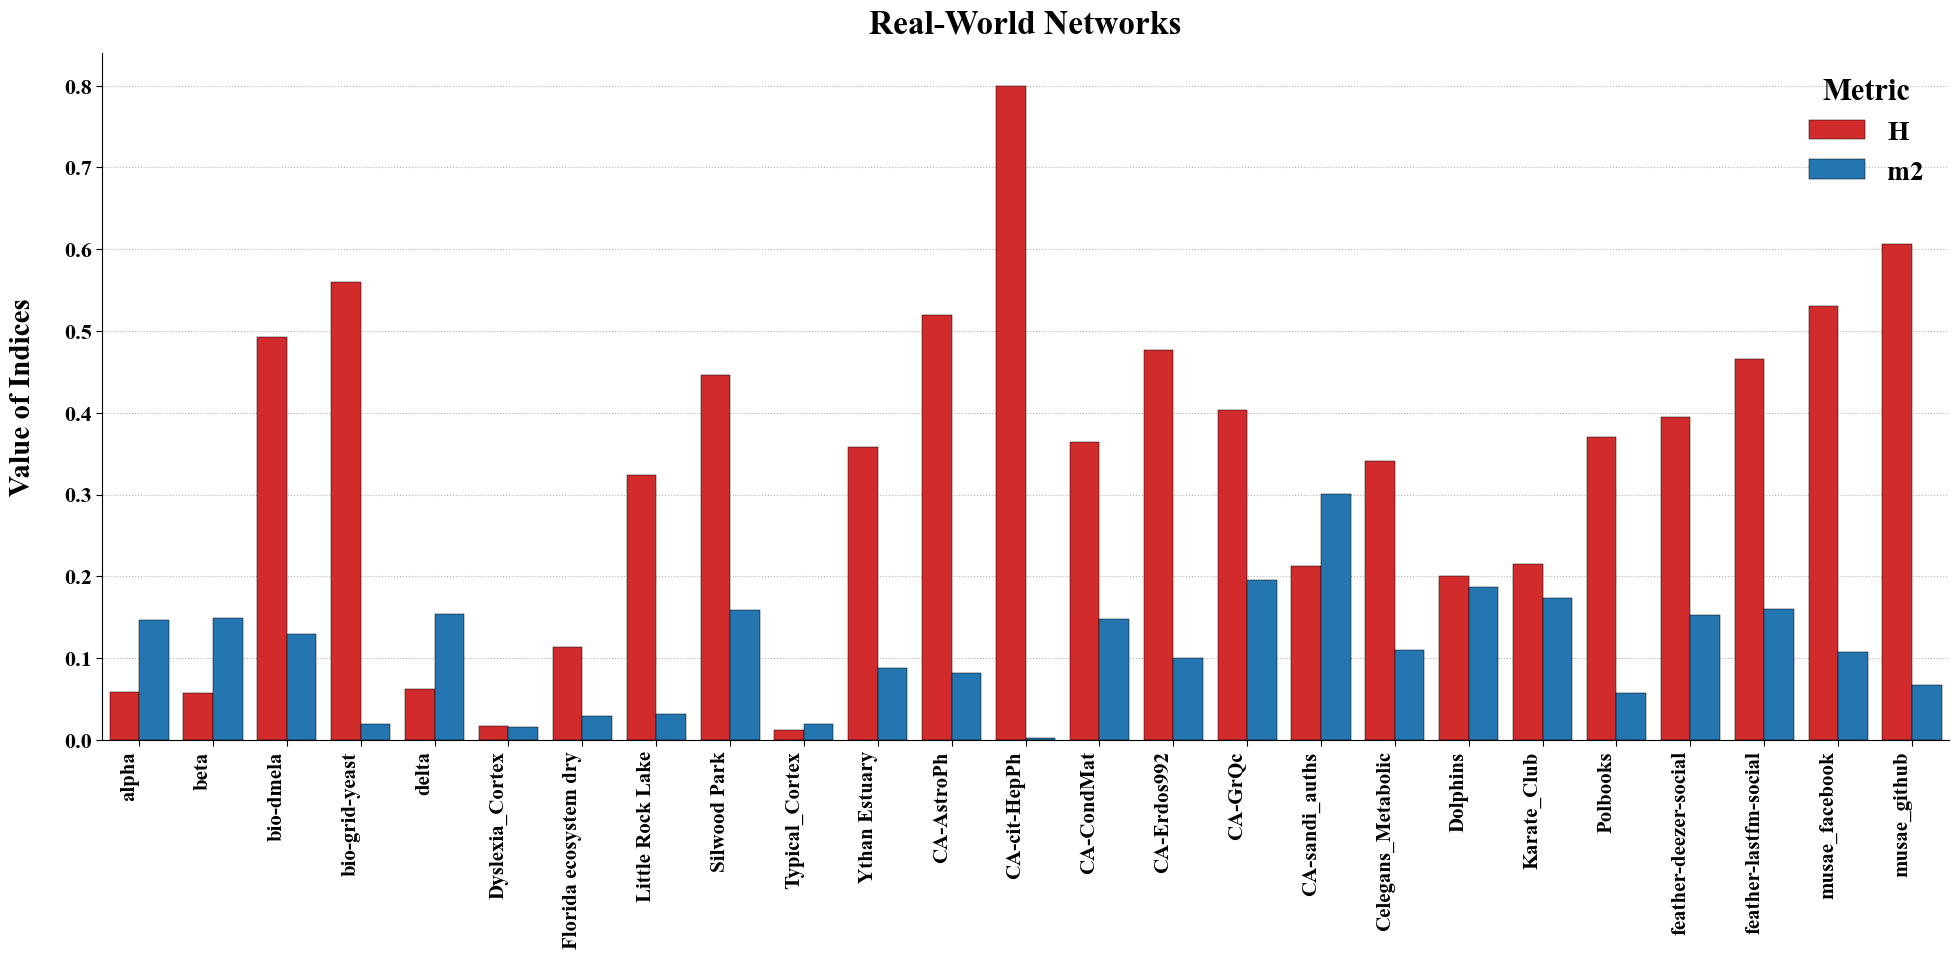

In [17]:
mpl.rcParams.update({
    'font.family': 'Times New Roman',
    'font.weight': 'bold',
    'font.size': 11,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})



name_map = {
    "alpha": "alpha",
    "beta": "beta",
    "bio-dmela": "bio-dmela",
    "bio-grid-yeast": "bio-grid-yeast",
    "delta": "delta",
    "Dyslexia_Cortex_64node": "Dyslexia_Cortex",
    "Florida ecosystem dry_128node_2106edge": "Florida ecosystem dry",
    "Little Rock Lake_182node": "Little Rock Lake",
    "Silwood Park_153node": "Silwood Park",
    "Typical_Cortex_64node": "Typical_Cortex",
    "Ythan Estuary_134node": "Ythan Estuary",
    "CA-AstroPh": "CA-AstroPh",
    "CA-cit-HepPh": "CA-cit-HepPh",
    "CA-CondMat": "CA-CondMat",
    "CA-Erdos992": "CA-Erdos992",
    "CA-GrQc": "CA-GrQc",
    "CA-sandi_auths": "CA-sandi_auths",
    "Celegans_Metabolic_453node": "Celegans_Metabolic",
    "Dolphins_63node": "Dolphins",
    "Karate_Club_33node": "Karate_Club",
    "Polbooks_241node": "Polbooks",
    "feather-deezer-social": "feather-deezer-social",
    "feather-lastfm-social": "feather-lastfm-social",
    "musae_facebook": "musae_facebook",
    "musae_github": "musae_github",
}


combined_df_reset = combined_df.reset_index(drop=True)

combined_df_reset['graph'] = combined_df_reset['graph'].replace(name_map)

df_long = pd.melt(
    combined_df_reset,
    id_vars='graph',
    value_vars=['H', 'm2'],
    var_name='Metric',
    value_name='Value'
)


plt.figure(figsize=(20, 10))

palette = {
    'H': '#D62728',   
    'm2': '#1F77B4',  
}

ax = sns.barplot(
    data=df_long,
    x='graph',
    y='Value',
    hue='Metric',
    palette=palette,
    edgecolor='black',
    linewidth=0.35,
    saturation=0.95
)


ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    ha='right',
    fontweight='bold'
)


ax.set_ylabel('Value of Indices', fontsize=21, fontweight='bold', labelpad=20)
ax.set_xlabel('')
ax.set_title('Real-World Networks', fontsize=24, fontweight='semibold', pad=15)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=16)

ax.grid(
    axis='y',
    color='gray',
    linestyle=':',
    linewidth=0.8,
    alpha=0.6
)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend = ax.legend(
    title='Metric',
    title_fontsize=22,
    fontsize=20,
    frameon=False,
    loc='upper right',
)
legend.get_title().set_weight('semibold')

plt.tight_layout(pad=2.0)
plt.savefig("Figures/real_worlds_networks_h_m2.png", dpi=1000, bbox_inches='tight')
plt.show()

In [18]:
combined_df = combined_df.drop(columns=['Unnamed: 0'], errors='ignore')

In [19]:
combined_df

,graph,Gini,H,m2,Q,estrada,CV,Q_norm,category
0,alpha,0.18,0.059,0.147,194.629,0.021,0.313,5.271095,Biological
1,beta,0.18,0.057,0.149,193.321,0.021,0.322,5.264352,Biological
2,bio-dmela,0.61,0.493,0.130,1665.605,0.317,1.559,7.417944,Biological
3,bio-grid-yeast,0.60,0.560,0.019,10366.167,0.327,1.547,9.246303,Biological
4,delta,0.18,0.062,0.154,189.181,0.022,0.321,5.242704,Biological
5,Dyslexia_Cortex_64node,0.04,0.017,0.016,4.298,0.009,0.137,1.458150,Biological
6,Florida ecosystem dry_128node_2106edge,0.25,0.114,0.029,57.619,0.068,0.487,4.053852,Biological
7,Little Rock Lake_182node,0.42,0.324,0.032,108.350,0.218,0.786,4.685367,Biological
8,Silwood Park_153node,0.58,0.446,0.159,263.334,0.388,1.467,5.573423,Biological
9,Typical_Cortex_64node,0.07,0.012,0.019,2.584,0.008,0.140,0.949339,Biological


In [20]:
corr_matrix = combined_df.drop(columns=['graph', 'category'])
corr_matrix


,Gini,H,m2,Q,estrada,CV,Q_norm
0,0.18,0.059,0.147,194.629,0.021,0.313,5.271095
1,0.18,0.057,0.149,193.321,0.021,0.322,5.264352
2,0.61,0.493,0.130,1665.605,0.317,1.559,7.417944
3,0.60,0.560,0.019,10366.167,0.327,1.547,9.246303
4,0.18,0.062,0.154,189.181,0.022,0.321,5.242704
5,0.04,0.017,0.016,4.298,0.009,0.137,1.458150
6,0.25,0.114,0.029,57.619,0.068,0.487,4.053852
7,0.42,0.324,0.032,108.350,0.218,0.786,4.685367
8,0.58,0.446,0.159,263.334,0.388,1.467,5.573423
9,0.07,0.012,0.019,2.584,0.008,0.140,0.949339


In [21]:
combined_df.dtypes

graph        object
Gini        float64
H           float64
m2          float64
Q           float64
estrada     float64
CV          float64
Q_norm      float64
category     object
dtype: object

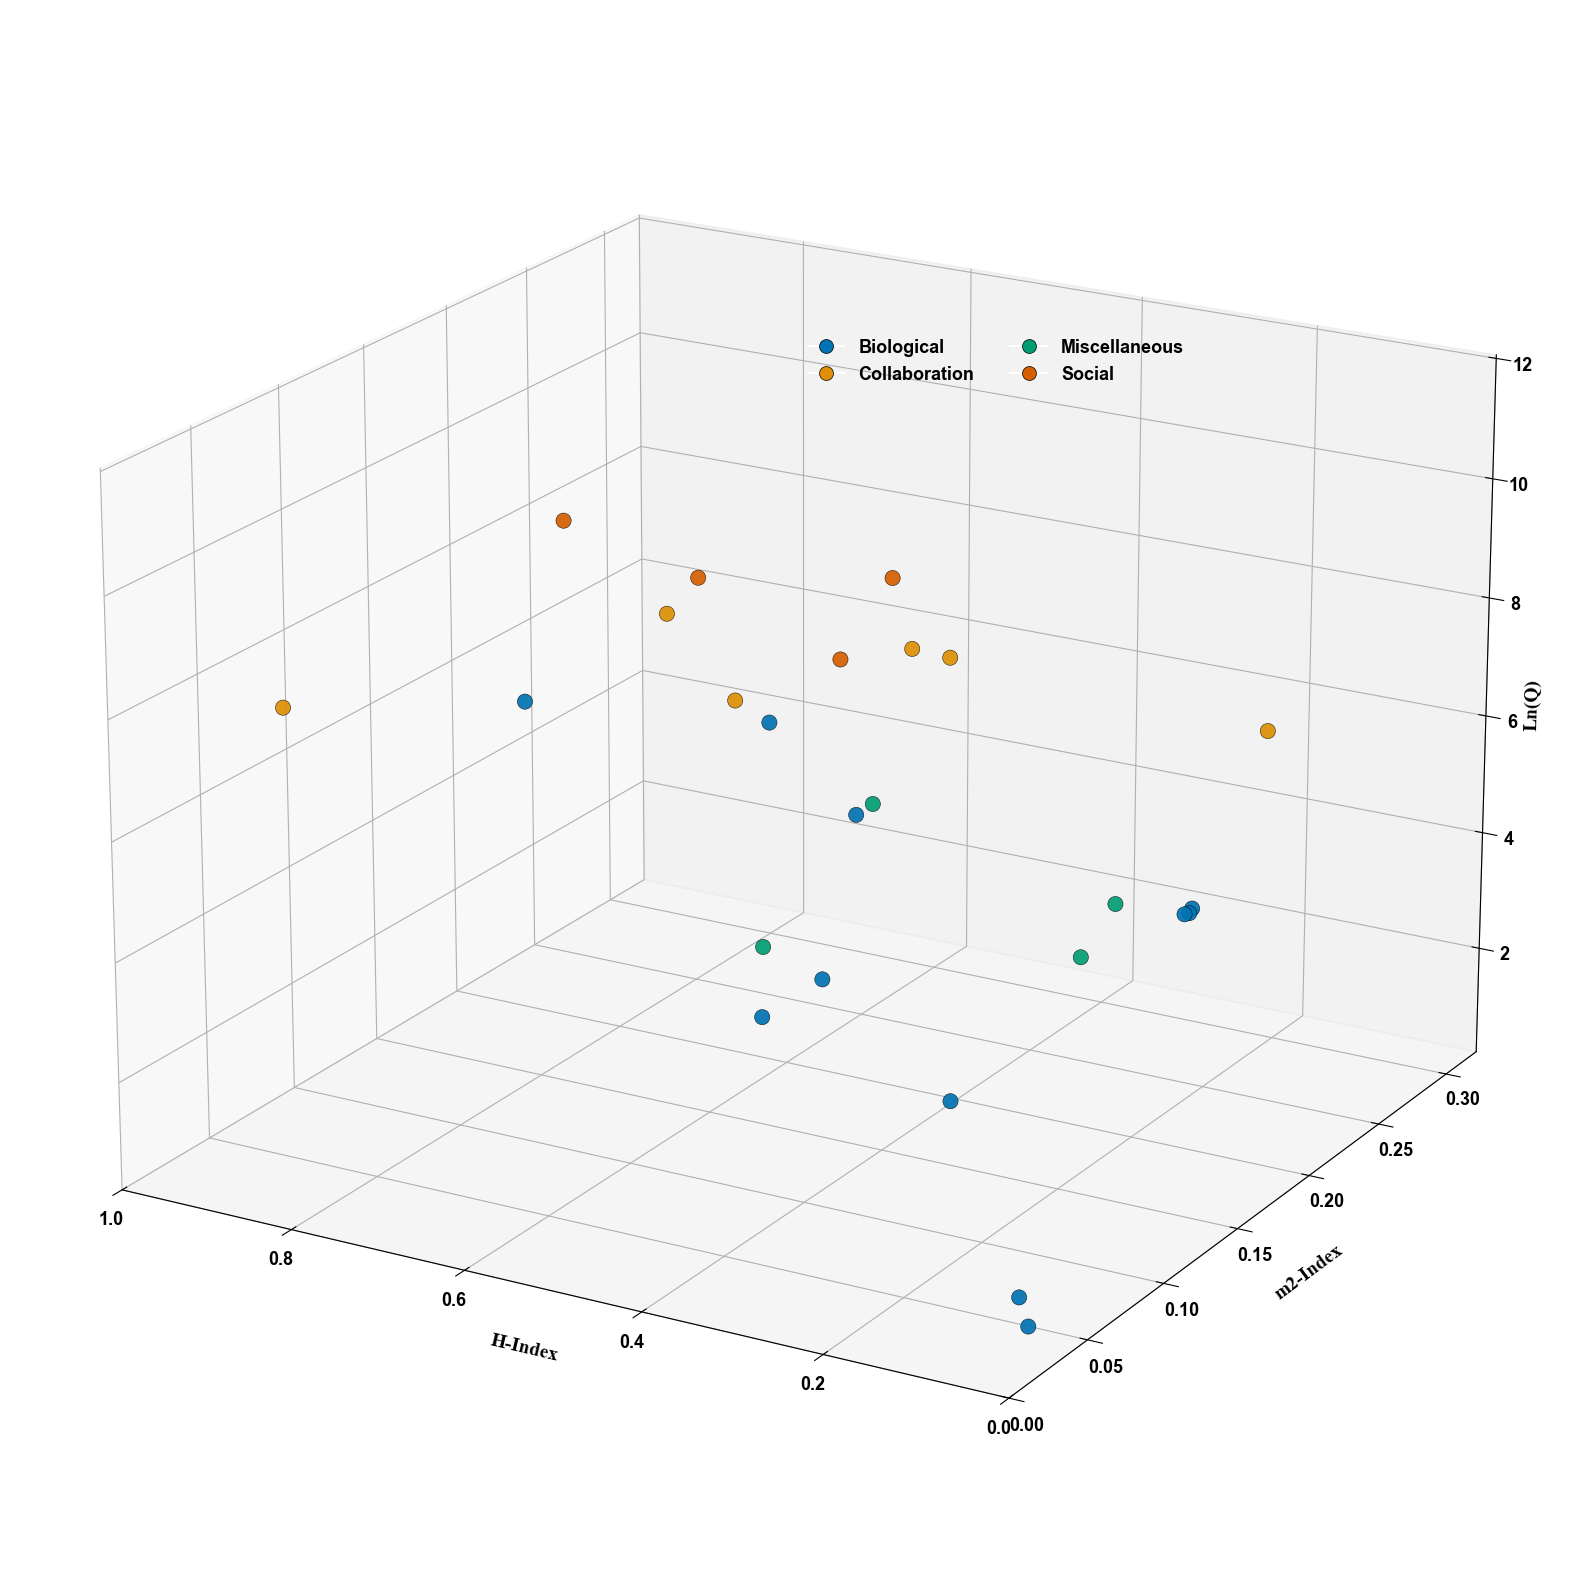

In [22]:
mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'axes.linewidth': 0.8,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})



categories = combined_df['category'].dropna().unique()
palette = sns.color_palette("colorblind", n_colors=len(categories))
color_dict = {cat: palette[i] for i, cat in enumerate(categories)}

# fig = plt.figure(figsize=(20, 16))
fig = plt.figure(figsize=(16, 16))

ax = fig.add_subplot(111, projection='3d')


xs = combined_df['H']
ys = combined_df['m2']
zs = combined_df['Q_norm']
colors = combined_df['category'].map(color_dict)

scatter = ax.scatter(
    xs, ys, zs,
    c=colors,
    s=120,
    edgecolor='black',
    linewidth=0.35,
    alpha=0.92
)

ax.set_xlabel('H-Index',
              fontfamily='Times New Roman',
              weight='bold',
              fontsize=14,
              labelpad=10)

ax.set_ylabel('m2-Index',
              fontfamily='Times New Roman',
              weight='bold',
              fontsize=14,
              labelpad=15)

ax.set_zlabel('Ln(Q)',
              fontfamily='Times New Roman',
              weight='bold',
              fontsize=14,
              labelpad=-0.5) 


ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.tick_params(axis='z', labelsize=13)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=cat,
           markerfacecolor=color_dict[cat], markersize=10,
           markeredgecolor='black', markeredgewidth=0.5)
    for cat in categories
]

legend = ax.legend(
    handles=legend_elements,
    title='',
    title_fontsize=15,
    fontsize=13,
    frameon=False,
    loc='upper left',
    ncol=2,
    bbox_to_anchor=(0.5, 0.8)
)
legend.get_title().set_weight('semibold')

ax.view_init(elev=20, azim=-60)
ax.grid(True, color='gray', linestyle=':', alpha=0.4)

plt.tight_layout(pad=1.2)
ax.set_xlim(right=0, left=1)
ax.set_ylim(bottom=0) 
plt.savefig('Figures/real.png', facecolor='white', dpi=1000, bbox_inches='tight')
plt.show()

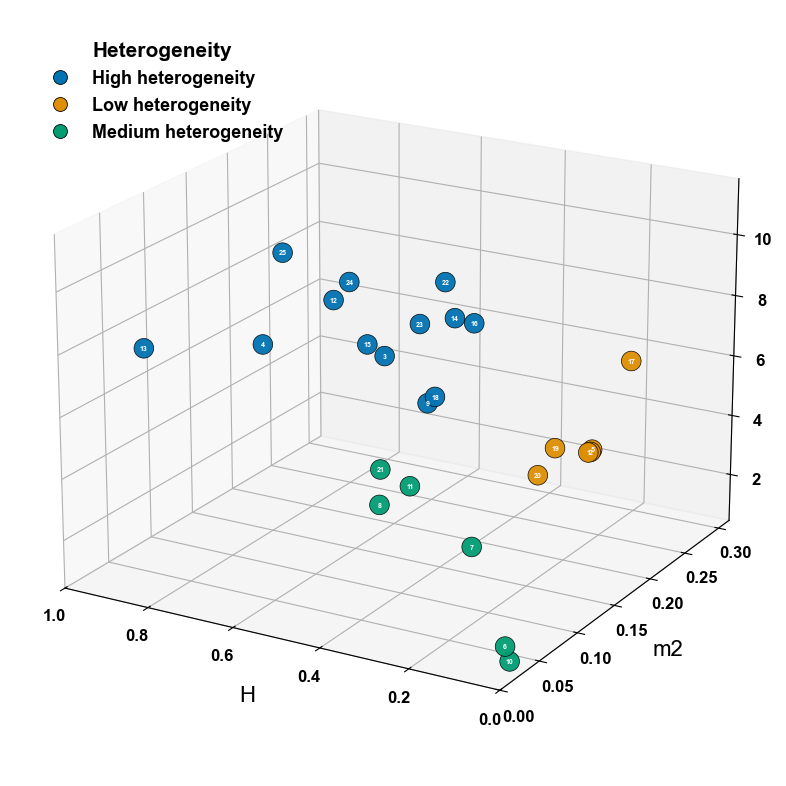

Mapping of Annotation Numbers to Graph Names:
0                                      alpha
1                                       beta
2                                  bio-dmela
3                             bio-grid-yeast
4                                      delta
5                     Dyslexia_Cortex_64node
6     Florida ecosystem dry_128node_2106edge
7                   Little Rock Lake_182node
8                       Silwood Park_153node
9                      Typical_Cortex_64node
10                     Ythan Estuary_134node
11                                CA-AstroPh
12                              CA-cit-HepPh
13                                CA-CondMat
14                               CA-Erdos992
15                                   CA-GrQc
16                            CA-sandi_auths
17                Celegans_Metabolic_453node
18                           Dolphins_63node
19                        Karate_Club_33node
20                          Polbooks_241node
21       

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'axes.linewidth': 0.8,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 12
})

results_df = combined_df[combined_df['graph'] != 'florida_bay'].reset_index(drop=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(results_df[['H', 'm2', 'Q_norm']])

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(scaled_features)

semantic_labels = ['High heterogeneity', 'Low heterogeneity', 'Medium heterogeneity']
results_df = results_df.copy()
results_df['category'] = [semantic_labels[l] for l in labels]

categories = [cat for cat in semantic_labels if cat in results_df['category'].values]
palette = sns.color_palette("colorblind", n_colors=len(categories))
color_dict = {cat: palette[i] for i, cat in enumerate(categories)}

xs = results_df['H']
ys = results_df['m2']
zs = results_df['Q_norm']
colors = results_df['category'].map(color_dict)

def tight_limits(data, pad_frac=0.05):
    d_min, d_max = data.min(), data.max()
    if d_min == d_max:
        return d_min - 0.1, d_max + 0.1
    padding = (d_max - d_min) * pad_frac
    return d_min - padding, d_max + padding

x_min, x_max = tight_limits(xs)
y_min, y_max = tight_limits(ys)
z_min, z_max = tight_limits(zs)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, c=colors, s=200, edgecolor='black', linewidth=0.5, alpha=0.95)

for i in range(len(results_df)):
    ax.text(xs.iloc[i], ys.iloc[i], zs.iloc[i], f'{i + 1}', fontsize=5, fontweight='bold',
            color='white', ha='center', va='center', zorder=10)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

ax.set_xlabel('H', fontsize=16, labelpad=10)
ax.set_ylabel('m2', fontsize=16, labelpad=10)
ax.set_zlabel('Q', fontsize=16, labelpad=10)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='z', labelsize=12)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=cat,
           markerfacecolor=color_dict[cat], markersize=10,
           markeredgecolor='black', markeredgewidth=0.6)
    for cat in categories
]

legend = ax.legend(handles=legend_elements, title='Heterogeneity', title_fontsize=15,
                   fontsize=13, frameon=False, loc='upper left', bbox_to_anchor=(0.02, 0.98))
legend.get_title().set_weight('semibold')

ax.view_init(elev=20, azim=-60)
ax.grid(True, color='gray', linestyle=':', alpha=0.3)
ax.set_xlim(left=1, right=0)
ax.set_ylim(bottom=0) 
plt.tight_layout(pad=1.0)
plt.show()

print("Mapping of Annotation Numbers to Graph Names:")
print(results_df['graph'])

<Figure size 1000x600 with 0 Axes>

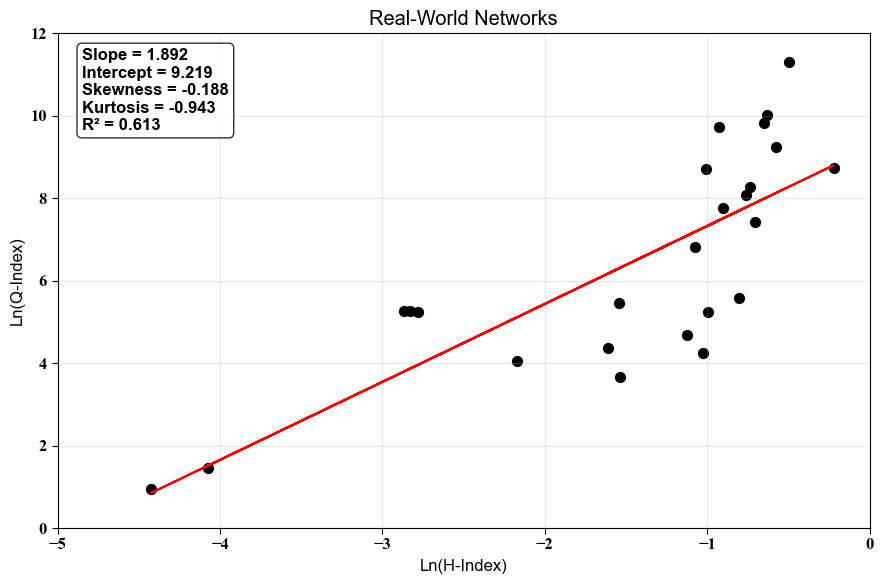

In [24]:
from scipy.stats import linregress, skew, kurtosis


plt.figure(figsize=(10, 6))
font = {'family': 'times new roman', 'weight': 'bold', 'size': 14}

df = combined_df.copy()

df['H_new'] = np.log(df['H'])
slope, intercept, r_value, p_value, std_err = linregress(df['H_new'], df['Q_norm'])
residuals = df['Q_norm'] - (slope * df['H_new'] + intercept)
skew_res = skew(residuals)
kurt_res = kurtosis(residuals)
r_squared = r_value ** 2

plt.figure(figsize=(9, 6))
plt.scatter(df['H_new'], df['Q_norm'], color='black', s=50)
plt.plot(df['H_new'], slope * df['H_new'] + intercept, 'r-')

plt.xlabel('Ln(H-Index)')
plt.ylabel('Ln(Q-Index)')
plt.xlim(-5, 0)  
plt.ylim(0,12)
plt.title('Real-World Networks')
plt.grid(True, alpha=0.3)

plt.xticks(fontfamily='Times New Roman', weight='bold')
plt.yticks(fontfamily='Times New Roman', weight='bold')

textstr = f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}\nSkewness = {skew_res:.3f}\nKurtosis = {kurt_res:.3f}\nR² = {r_squared:.3f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.03, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()

plt.savefig('Figures/q_h.png', facecolor='white', dpi=1000, bbox_inches='tight')

plt.show()

<Figure size 1000x600 with 0 Axes>

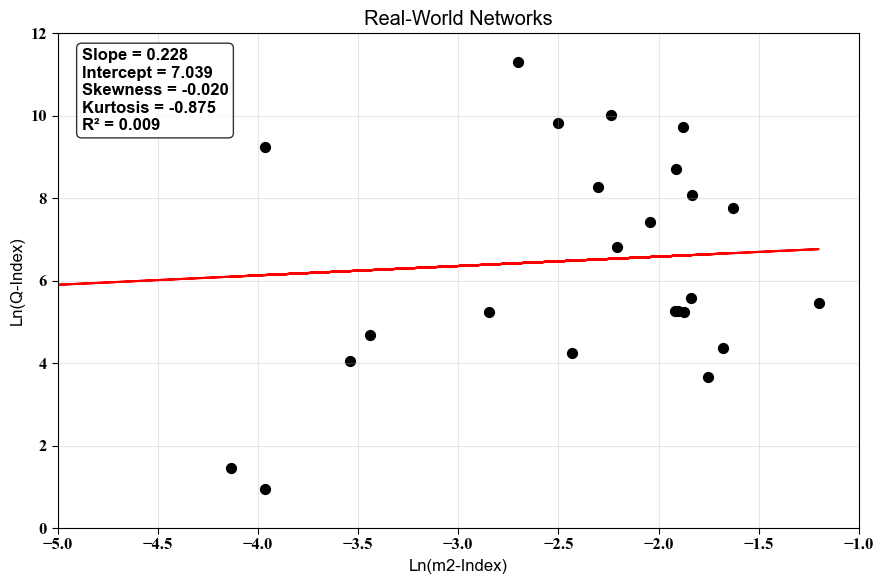

In [25]:
plt.figure(figsize=(10, 6))
font = {'family': 'times new roman', 'weight': 'bold', 'size': 14}
df = combined_df.copy()

df['m2_new'] = np.log(df['m2'])
slope, intercept, r_value, p_value, std_err = linregress(df['m2_new'], df['Q_norm'])
residuals = df['Q_norm'] - (slope * df['m2_new'] + intercept)
skew_res = skew(residuals)
kurt_res = kurtosis(residuals)
r_squared = r_value ** 2

plt.figure(figsize=(9, 6))
plt.scatter(df['m2_new'], df['Q_norm'], color='black', s=50)
plt.plot(df['m2_new'], slope * df['m2_new'] + intercept, 'r-')


plt.xlabel('Ln(m2-Index)')
plt.ylabel('Ln(Q-Index)')
plt.xlim(-5, -1)  
plt.ylim(0,12)
plt.title('Real-World Networks')
plt.grid(True, alpha=0.3)

plt.xticks(fontfamily='Times New Roman', weight='bold')
plt.yticks(fontfamily='Times New Roman', weight='bold')

textstr = f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}\nSkewness = {skew_res:.3f}\nKurtosis = {kurt_res:.3f}\nR² = {r_squared:.3f}'


props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.03, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.savefig('Figures/q_m2.png', facecolor='white', dpi=1000, bbox_inches='tight')


plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

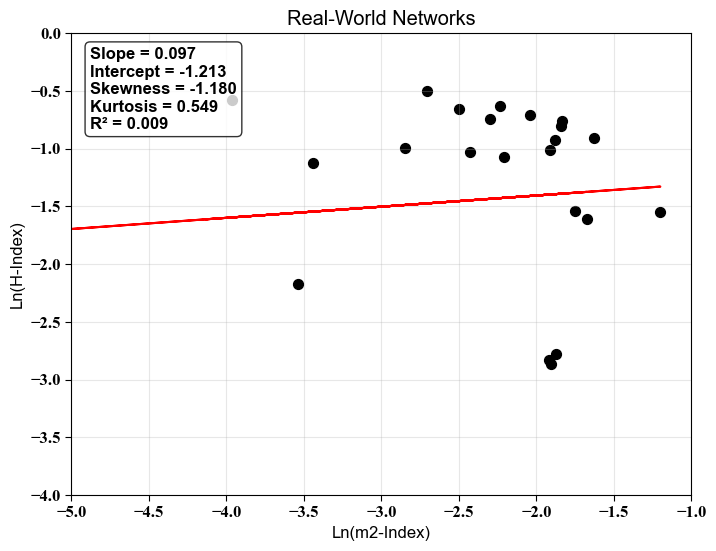

In [26]:
plt.figure(figsize=(10, 6))
font = {'family': 'times new roman', 'weight': 'bold', 'size': 14}

df = combined_df.copy()

df['m2_new'] = np.log(df['m2'])
df['H_new'] = np.log(df['H'])

slope, intercept, r_value, p_value, std_err = linregress(df['m2_new'], df['H_new'])
r_squared = r_value ** 2
residuals = df['H_new'] - (slope * df['m2_new'] + intercept)

skew_res = skew(residuals)
kurt_res = kurtosis(residuals)

plt.figure(figsize=(8, 6))
plt.scatter(df['m2_new'], df['H_new'], color='black', s=50)
plt.plot(df['m2_new'], slope * df['m2_new'] + intercept, 'r-')

plt.xlabel('Ln(m2-Index)')
plt.ylabel('Ln(H-Index)')
plt.xlim(-5, -1)  
plt.ylim(-4,0)
plt.title('Real-World Networks')
plt.grid(True, alpha=0.3)

plt.xticks(fontfamily='Times New Roman', weight='bold')
plt.yticks(fontfamily='Times New Roman', weight='bold')

textstr = f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}\nSkewness = {skew_res:.3f}\nKurtosis = {kurt_res:.3f}\nR² = {r_squared:.3f}'


props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.03, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.savefig('Figures/h_m2.png', facecolor='white', dpi=1000, bbox_inches='tight')


plt.show()

<Figure size 1000x600 with 0 Axes>

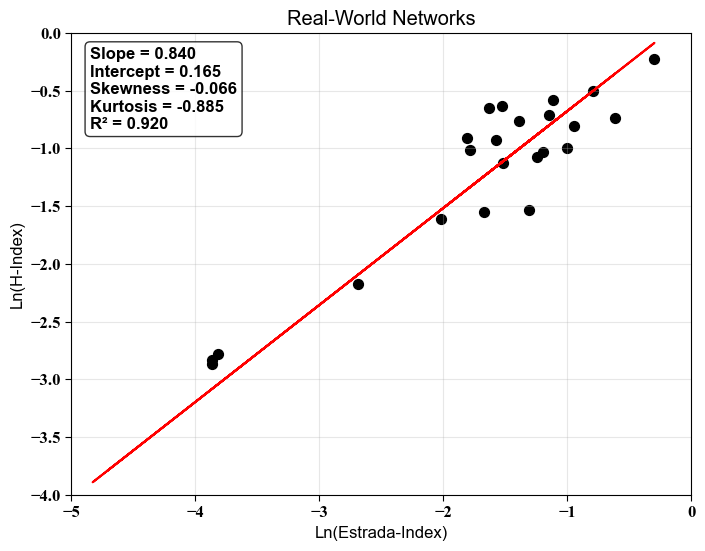

In [27]:
plt.figure(figsize=(10, 6))
font = {'family': 'times new roman', 'weight': 'bold', 'size': 14}

df = combined_df.copy()

df['estrada_new'] = np.log(df['estrada'])
df['H_new'] = np.log(df['H'])

slope, intercept, r_value, p_value, std_err = linregress(df['estrada_new'], df['H_new'])

residuals = df['H_new'] - (slope * df['estrada_new'] + intercept)

skew_res = skew(residuals)
kurt_res = kurtosis(residuals)
r_squared = r_value ** 2
plt.figure(figsize=(8, 6))
plt.scatter(df['estrada_new'], df['H_new'], color='black', s=50)
plt.plot(df['estrada_new'], slope * df['estrada_new'] + intercept, 'r-')


plt.xlabel('Ln(Estrada-Index)')
plt.ylabel('Ln(H-Index)')
plt.xlim(-5, 0)  
plt.ylim(-4,0)
plt.title('Real-World Networks')
plt.grid(True, alpha=0.3)


plt.xticks(fontfamily='Times New Roman', weight='bold')
plt.yticks(fontfamily='Times New Roman', weight='bold')

textstr = f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}\nSkewness = {skew_res:.3f}\nKurtosis = {kurt_res:.3f}\nR² = {r_squared:.3f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.03, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.savefig('Figures/h_estrada.png', facecolor='white', dpi=1000, bbox_inches='tight')


plt.show()

<Figure size 1000x600 with 0 Axes>

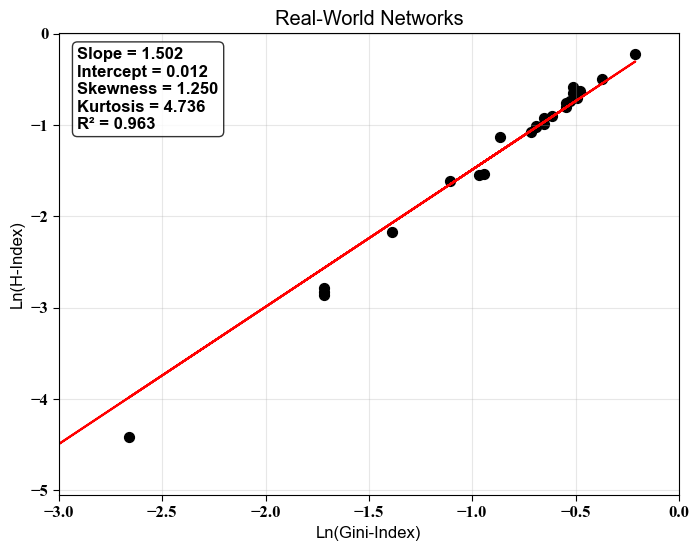

In [28]:
plt.figure(figsize=(10, 6))
font = {'family': 'times new roman', 'weight': 'bold', 'size': 14}


df = combined_df.copy()

df['gini_new'] = np.log(df['Gini'])
df['H_new'] = np.log(df['H'])

slope, intercept, r_value, p_value, std_err = linregress(df['gini_new'], df['H_new'])

residuals = df['H_new'] - (slope * df['gini_new'] + intercept)

skew_res = skew(residuals)
kurt_res = kurtosis(residuals)
r_squared = r_value ** 2

plt.figure(figsize=(8, 6))
plt.scatter(df['gini_new'], df['H_new'], color='black', s=50)
plt.plot(df['gini_new'], slope * df['gini_new'] + intercept, 'r-')
plt.xlabel('Ln(Gini-Index)')
plt.ylabel('Ln(H-Index)')
plt.title('Real-World Networks')
plt.grid(True, alpha=0.3)
plt.xticks(fontfamily='Times New Roman', weight='bold')
plt.yticks(fontfamily='Times New Roman', weight='bold')
plt.xlim(-3,0)

textstr = f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}\nSkewness = {skew_res:.3f}\nKurtosis = {kurt_res:.3f}\nR² = {r_squared:.3f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.03, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.savefig('Figures/h_gini.png', facecolor='white', dpi=1000, bbox_inches='tight')

plt.show()

<Figure size 1000x600 with 0 Axes>

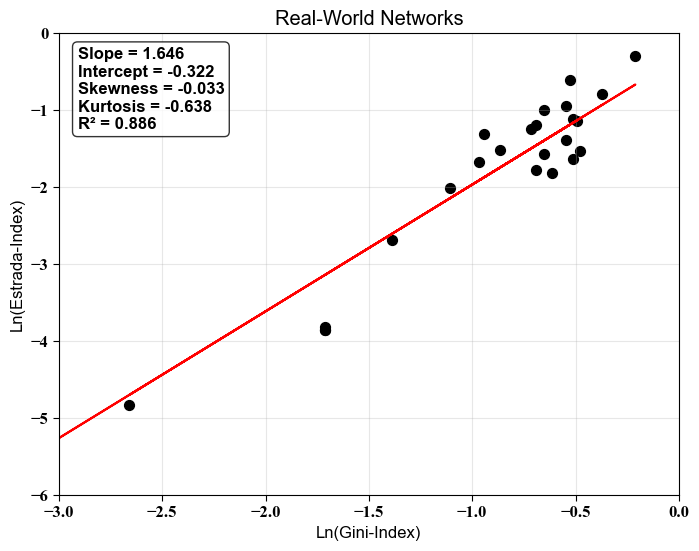

In [29]:
plt.figure(figsize=(10, 6))
font = {'family': 'times new roman', 'weight': 'bold', 'size': 14}


df = combined_df.copy()

df['gini_new'] = np.log(df['Gini'])
df['estrada_new'] = np.log(df['estrada'])

slope, intercept, r_value, p_value, std_err = linregress(df['gini_new'], df['estrada_new'])

residuals = df['estrada_new'] - (slope * df['gini_new'] + intercept)
r_squared = r_value ** 2
skew_res = skew(residuals)
kurt_res = kurtosis(residuals)

plt.figure(figsize=(8, 6))
plt.scatter(df['gini_new'], df['estrada_new'], color='black', s=50)
plt.plot(df['gini_new'], slope * df['gini_new'] + intercept, 'r-')

plt.xlabel('Ln(Gini-Index)')
plt.ylabel('Ln(Estrada-Index)')

plt.title('Real-World Networks')
plt.grid(True, alpha=0.3)
plt.xticks(fontfamily='Times New Roman', weight='bold')
plt.yticks(fontfamily='Times New Roman', weight='bold')
plt.xlim(-3,0)
plt.ylim(-6, 0)

textstr = f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}\nSkewness = {skew_res:.3f}\nKurtosis = {kurt_res:.3f}\nR² = {r_squared:.3f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.03, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.savefig('Figures/estrada_gini.png', facecolor='white', dpi=1000, bbox_inches='tight')


plt.show()